In [1]:
%matplotlib inline


# standard library
import os
import time
from pathlib import Path

# data munging
import pandas as pd
import numpy as np

# model building
import tensorflow as tf

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use(style="seaborn")
# plt.rcParams['figure.dpi'] = 400
sns.set_style('whitegrid')



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
!nvidia-smi

Thu Jul 14 05:20:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P2    52W / 200W |   2688MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
ticker_list = ["aapl", "amzn", "msft"]

ticker = ticker_list[0]

ticker_upper = ticker.upper()

print("Ticker:", ticker_upper)

################################################

source_list = ["BENZINGA", "TWINT"]

source = source_list[1]

print("Source:", source)

################################################

model_type_list = ["univariate", "multivariate", "multivariate_with_news_sentiment", "multivariate_with_tweet_sentiment"]

model_type = model_type_list[3]

print("Model Type:", model_type.upper())

################################################

include_logged_returns = True

print("Include Logged Returns:", include_logged_returns)

################################################

training_length_list = ["low", "high"]

training_length = training_length_list[0]

if training_length == "low":
    MAX_EPOCHS = 100
    patience=30
elif training_length == "high":
    MAX_EPOCHS = 500
    patience=50

print("Max Epochs:", MAX_EPOCHS)
print("Patience:", patience)

Ticker: AAPL
Source: TWINT
Model Type: MULTIVARIATE_WITH_TWEET_SENTIMENT
Include Logged Returns: True
Max Epochs: 100
Patience: 30


In [5]:
csv_path = f"/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/{ticker_upper}/{ticker_upper}_WITH_{source}_FINBERT_SA.csv"

In [6]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df.index = date_time

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
 8   date_time             3064 non-null   object 
 9   day_of_week           3064 non-null   int64  
 10  return                3064 non-null   float64
 11  increase              3064 non-null   float64
 12  log_return            3064 non-null   float64
 13  negative              3064 non-null   float64
 14  nuetral               3064 non-null   float64
 15  pos

In [8]:
df.describe()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,day_of_week,return,increase,log_return,negative,nuetral,positive
count,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3.064000e+03,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000
mean,260.329399,262.829696,257.667717,260.335499,42.736360,3.829313e+07,0.013270,1.002937,2.022846,0.001207,0.529047,0.001050,0.158588,0.090758,0.748042
std,159.641209,161.044982,157.946296,159.521075,41.154337,3.233265e+07,0.160922,0.121173,1.399408,0.017675,0.499237,0.017688,0.143203,0.123167,0.176529
min,90.000000,90.700000,89.470000,90.280000,5.872396,5.624800e+06,0.000000,1.000000,0.000000,-0.128647,0.000000,-0.137708,0.000000,0.000000,0.000000
25%,128.377500,129.535000,127.102500,128.525000,16.285903,1.762402e+07,0.000000,1.000000,1.000000,-0.007140,0.000000,-0.007166,0.027276,0.000811,0.651903
50%,192.135000,194.330000,190.875000,192.255000,26.270965,2.763896e+07,0.000000,1.000000,2.000000,0.000942,1.000000,0.000942,0.140013,0.050226,0.762676
75%,364.102500,369.210000,358.682500,364.282500,48.589739,4.667886e+07,0.000000,1.000000,3.000000,0.010459,1.000000,0.010404,0.242063,0.137521,0.865595
max,702.410000,705.070000,699.570000,702.100000,181.778019,3.326072e+08,3.290000,7.000007,4.000000,0.119808,1.000000,0.113157,1.000000,0.999997,0.999999


Text(0.5, 0, 'Date')

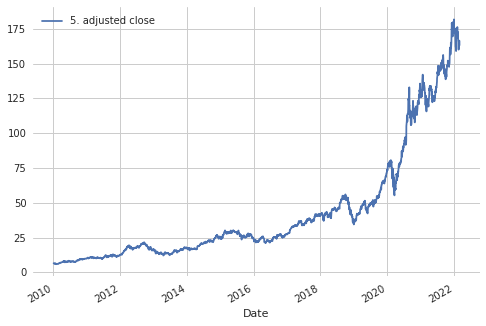

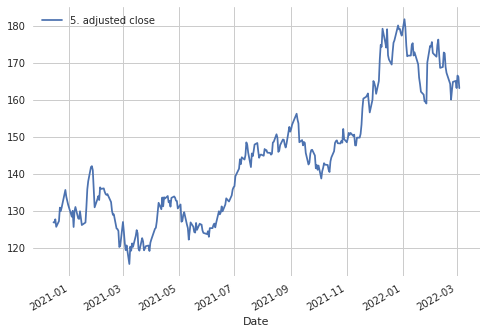

In [9]:
plot_cols = ['5. adjusted close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
plt.xlabel('Date')

plot_features = df[plot_cols][2757:]
plot_features.index = date_time[2757:]
_ = plot_features.plot(subplots=True)
plt.xlabel('Date')

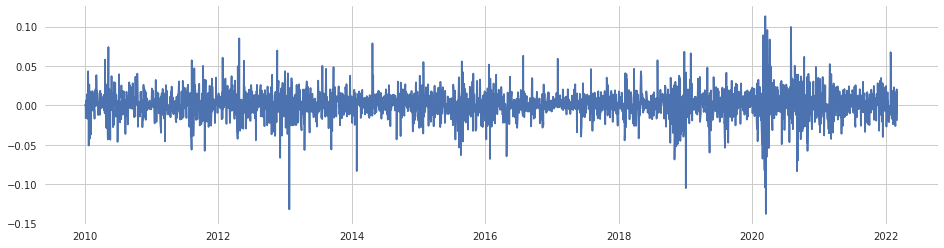

In [10]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_return)
plt.title("Logged Returns")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
 8   date_time             3064 non-null   object 
 9   day_of_week           3064 non-null   int64  
 10  return                3064 non-null   float64
 11  increase              3064 non-null   float64
 12  log_return            3064 non-null   float64
 13  negative              3064 non-null   float64
 14  nuetral               3064 non-null   float64
 15  pos

In [12]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.543876,17633200.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.000013,0.000009,0.999979
2010-01-05,214.60,215.59,213.25,214.38,6.555190,21496600.0,0.0,1.0,2010-01-05,1,0.001729,1.0,0.001727,0.498715,0.001116,0.500169
2010-01-06,214.38,215.23,210.75,210.97,6.450921,19720000.0,0.0,1.0,2010-01-06,2,-0.015906,0.0,-0.016034,0.000052,0.085701,0.914247
2010-01-07,211.75,212.00,209.05,210.58,6.438996,17040400.0,0.0,1.0,2010-01-07,3,-0.001849,0.0,-0.001850,0.457010,0.000224,0.542766
2010-01-08,210.30,212.00,209.06,211.98,6.481804,15986100.0,0.0,1.0,2010-01-08,4,0.006648,1.0,0.006626,0.010157,0.000059,0.989783


In [13]:
df.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2022-02-28,163.060,165.42,162.43,165.12,165.12,95056629.0,0.0,1.0,2022-02-28,0,0.001638,1.0,0.001637,0.110022,0.022801,0.867177
2022-03-01,164.695,166.60,161.97,163.20,163.20,83474425.0,0.0,1.0,2022-03-01,1,-0.011628,0.0,-0.011696,0.083351,0.250679,0.665971
2022-03-02,164.390,167.36,162.95,166.56,166.56,79724750.0,0.0,1.0,2022-03-02,2,0.020588,1.0,0.020379,0.150388,0.000115,0.849497
2022-03-03,168.470,168.91,165.55,166.23,166.23,76678441.0,0.0,1.0,2022-03-03,3,-0.001981,0.0,-0.001983,0.132856,0.000441,0.866703
2022-03-04,164.490,165.55,162.10,163.17,163.17,83819592.0,0.0,1.0,2022-03-04,4,-0.018408,0.0,-0.018580,0.132856,0.000441,0.866703


In [14]:
# df["increase"] = df["increase"].shift(1)
# df["log_return"] = df["log_return"].shift(1)

In [15]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.543876,17633200.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.000013,0.000009,0.999979
2010-01-05,214.60,215.59,213.25,214.38,6.555190,21496600.0,0.0,1.0,2010-01-05,1,0.001729,1.0,0.001727,0.498715,0.001116,0.500169
2010-01-06,214.38,215.23,210.75,210.97,6.450921,19720000.0,0.0,1.0,2010-01-06,2,-0.015906,0.0,-0.016034,0.000052,0.085701,0.914247
2010-01-07,211.75,212.00,209.05,210.58,6.438996,17040400.0,0.0,1.0,2010-01-07,3,-0.001849,0.0,-0.001850,0.457010,0.000224,0.542766
2010-01-08,210.30,212.00,209.06,211.98,6.481804,15986100.0,0.0,1.0,2010-01-08,4,0.006648,1.0,0.006626,0.010157,0.000059,0.989783


In [16]:
df.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2022-02-28,163.060,165.42,162.43,165.12,165.12,95056629.0,0.0,1.0,2022-02-28,0,0.001638,1.0,0.001637,0.110022,0.022801,0.867177
2022-03-01,164.695,166.60,161.97,163.20,163.20,83474425.0,0.0,1.0,2022-03-01,1,-0.011628,0.0,-0.011696,0.083351,0.250679,0.665971
2022-03-02,164.390,167.36,162.95,166.56,166.56,79724750.0,0.0,1.0,2022-03-02,2,0.020588,1.0,0.020379,0.150388,0.000115,0.849497
2022-03-03,168.470,168.91,165.55,166.23,166.23,76678441.0,0.0,1.0,2022-03-03,3,-0.001981,0.0,-0.001983,0.132856,0.000441,0.866703
2022-03-04,164.490,165.55,162.10,163.17,163.17,83819592.0,0.0,1.0,2022-03-04,4,-0.018408,0.0,-0.018580,0.132856,0.000441,0.866703


In [17]:
df.fillna(0.0, inplace=True)

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1. open,3064.0,2.603294e+02,1.596412e+02,9.000000e+01,1.283775e+02,1.921350e+02,3.641025e+02,7.024100e+02
2. high,3064.0,2.628297e+02,1.610450e+02,9.070000e+01,1.295350e+02,1.943300e+02,3.692100e+02,7.050700e+02
3. low,3064.0,2.576677e+02,1.579463e+02,8.947000e+01,1.271025e+02,1.908750e+02,3.586825e+02,6.995700e+02
4. close,3064.0,2.603355e+02,1.595211e+02,9.028000e+01,1.285250e+02,1.922550e+02,3.642825e+02,7.021000e+02
5. adjusted close,3064.0,4.273636e+01,4.115434e+01,5.872396e+00,1.628590e+01,2.627096e+01,4.858974e+01,1.817780e+02
6. volume,3064.0,3.829313e+07,3.233265e+07,5.624800e+06,1.762402e+07,2.763896e+07,4.667886e+07,3.326072e+08
7. dividend amount,3064.0,1.327023e-02,1.609221e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.290000e+00
8. split coefficient,3064.0,1.002937e+00,1.211729e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000007e+00
day_of_week,3064.0,2.022846e+00,1.399408e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
return,3064.0,1.206562e-03,1.767537e-02,-1.286470e-01,-7.140032e-03,9.419846e-04,1.045851e-02,1.198082e-01


In [19]:
# if model_type == "univariate":
#     if not include_logged_returns:
#         feature_list = ["5. adjusted close"]
#     else:
#         feature_list = ["5. adjusted close", "log_return"]

# elif model_type == "multivariate":
#     if not include_logged_returns:
#         feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume"]
#     else:
#         feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "log_return"]

# elif model_type == "multivariate_with_news_sentiment" or model_type == "multivariate_with_tweet_sentiment":
#     if not include_logged_returns:
#         feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "negative", "nuetral", "positive"]
#     else:
#         feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "negative", "nuetral", "positive", "log_return"]


feature_list = ["increase", "log_return", "negative", "nuetral", "positive"]


X = df[feature_list].values


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

In [22]:
y = [x[0] for x in X_scaled]

#### Train test split

In [23]:
split = int(len(X_scaled) * 0.9)
print(split)

2757


In [24]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

In [25]:
print(len(X_train))
print(len(X_test))

2757
307


In [26]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

#### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [27]:
n = 63
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

In [28]:
df.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.543876,17633200.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.000013,0.000009,0.999979
2010-01-05,214.60,215.59,213.25,214.38,6.555190,21496600.0,0.0,1.0,2010-01-05,1,0.001729,1.0,0.001727,0.498715,0.001116,0.500169
2010-01-06,214.38,215.23,210.75,210.97,6.450921,19720000.0,0.0,1.0,2010-01-06,2,-0.015906,0.0,-0.016034,0.000052,0.085701,0.914247
2010-01-07,211.75,212.00,209.05,210.58,6.438996,17040400.0,0.0,1.0,2010-01-07,3,-0.001849,0.0,-0.001850,0.457010,0.000224,0.542766
2010-01-08,210.30,212.00,209.06,211.98,6.481804,15986100.0,0.0,1.0,2010-01-08,4,0.006648,1.0,0.006626,0.010157,0.000059,0.989783


In [29]:
ytrain[0]

1.0

In [30]:
len(feature_list)

5

In [31]:
_ = np.array(ytrain[0])

if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]     

In [32]:
scaler.inverse_transform(_)

array([[ 1.        , -0.13770808,  0.        ,  0.        ,  0.        ]])

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [33]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [34]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2694, 63, 5)
(2694,)
---
(244, 63, 5)
(244,)


#### LSTM Model

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [36]:
results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [37]:
# MAX_EPOCHS = 500
MAX_EPOCHS = 100
# patience=50
patience=30

lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

# optimizer = tf.keras.optimizers.Adam()

def compile_and_fit(model, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',  
                                                    restore_best_weights=True)

  model.compile(# loss=tf.losses.BinaryCrossentropy(from_logits=True),
                loss=tf.losses.BinaryCrossentropy(),
                optimizer=optimizer,
                metrics=[tf.metrics.BinaryAccuracy()])

  history = model.fit(Xtrain, ytrain, epochs=MAX_EPOCHS,
                      validation_data=(Xtest, ytest),
                      callbacks=[early_stopping, checkpointer],
                      batch_size=32,
                      shuffle=True,
                      verbose=1)
  return history


In [38]:
from keras.layers import Dropout, Dense

In [39]:
model = Sequential([
    LSTM(units=64, 
         return_sequences=False,
         # Shape => [batch, time, features]
         input_shape=(Xtrain.shape[1], Xtrain.shape[2]), 
         name='LSTM'),
    # Dropout(0.20),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid', name='Output')
    # Dense(1, name='Output')
])

In [40]:
history = compile_and_fit(model)


Epoch 1/100
83/85 [============================>.] - ETA: 0s - loss: 0.6954 - binary_accuracy: 0.5162
Epoch 1: val_loss improved from inf to 0.69462, saving model to results/lstm/lstm.h5
85/85 [==============================] - 7s 25ms/step - loss: 0.6953 - binary_accuracy: 0.5163 - val_loss: 0.6946 - val_binary_accuracy: 0.4754
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.6965 - binary_accuracy: 0.5186
Epoch 2: val_loss improved from 0.69462 to 0.69280, saving model to results/lstm/lstm.h5
85/85 [==============================] - 2s 22ms/step - loss: 0.6965 - binary_accuracy: 0.5186 - val_loss: 0.6928 - val_binary_accuracy: 0.5246
Epoch 3/100
83/85 [============================>.] - ETA: 0s - loss: 0.6927 - binary_accuracy: 0.5271
Epoch 3: val_loss improved from 0.69280 to 0.69195, saving model to results/lstm/lstm.h5
85/85 [==============================] - 2s 20ms/step - loss: 0.6925 - binary_accuracy: 0.5293 - val_loss: 0.6919 - val_binary_accuracy: 0.5246

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 18,581
Trainable params: 18,581
Non-trainable params: 0
_________________________________________________________________


In [42]:
train_predict_scaled = model.predict(Xtrain).squeeze()
test_predict_scaled = model.predict(Xtest).squeeze()

print(len(train_predict_scaled))
print(len(test_predict_scaled))

2694
244


In [43]:
model.evaluate(Xtrain, ytrain)

85/85 [==============================] - 1s 11ms/step - loss: 0.6900 - binary_accuracy: 0.5338


[0.6900391578674316, 0.5337787866592407]

In [44]:
model.evaluate(Xtest, ytest)

8/8 [==============================] - 0s 10ms/step - loss: 0.6880 - binary_accuracy: 0.5492


[0.6879858374595642, 0.5491803288459778]

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
# calculate mean absolute error
trainScore = accuracy_score(ytrain, train_predict_scaled.round())
print("Train Score: %.4f Accuracy" % (trainScore))

testScore = accuracy_score(ytest, test_predict_scaled.round())
print("Test Score: %.4f Accuracy" % (testScore))

Train Score: 0.5338 Accuracy
Test Score: 0.5492 Accuracy


In [47]:
_ = np.array(train_predict_scaled)


if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]     

In [48]:
_train_predict_scaled = scaler.inverse_transform(_)

In [49]:
_train_predict_scaled[0][0]

0.5571150183677673

In [50]:
train_predict_rescaled = np.zeros([2694,], dtype='float32')

In [51]:
for i, x in enumerate(_train_predict_scaled):
    if x[0] > .5:
        train_predict_rescaled[i] = 1
    else:
        train_predict_rescaled[i] = 0

In [52]:
train_predict_rescaled[0]

1.0

In [53]:
train_predict_rescaled = pd.Series(train_predict_rescaled, index=df.iloc[63:split].index)


In [54]:
_ = np.array(test_predict_scaled)


if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]     

In [55]:
_test_predict_scaled = scaler.inverse_transform(_)

In [56]:
_test_predict_scaled[0][0]

0.5674586892127991

In [57]:
test_predict_rescaled = np.zeros([244,], dtype='float32')

In [58]:
for i, x in enumerate(_test_predict_scaled):
    if x[0] > .5:
        test_predict_rescaled[i] = 1
    else:
        test_predict_rescaled[i] = 0

In [59]:
test_predict_rescaled = pd.Series(test_predict_rescaled, index=df.iloc[split+63:].index)

In [60]:
df_compare = df.iloc[-244:].copy()

In [61]:
df_compare["preds"] = test_predict_rescaled

In [62]:
df_compare = df_compare[['5. adjusted close', 'preds', 'return', 'increase']].copy()

In [63]:
df_compare.increase.value_counts()

1.0    128
0.0    116
Name: increase, dtype: int64

In [64]:
df_compare.increase.value_counts(normalize=True)

1.0    0.52459
0.0    0.47541
Name: increase, dtype: float64

In [65]:
df_compare.preds.value_counts()

1.0    178
0.0     66
Name: preds, dtype: int64

In [66]:
df_compare.preds.value_counts(normalize=True)

1.0    0.729508
0.0    0.270492
Name: preds, dtype: float64

In [67]:
testScore = accuracy_score(df_compare["increase"].values, df_compare["preds"].values)
print("Test Score: %.4f Accuracy" % (testScore))

Test Score: 0.5492 Accuracy


In [68]:
df_compare.head()

,5. adjusted close,preds,return,increase
date,,,,
2021-03-18,119.818452,1.0,-0.033905,0.0
2021-03-19,119.281640,1.0,-0.004480,0.0
2021-03-22,122.661568,1.0,0.028336,1.0
2021-03-23,121.816586,1.0,-0.006889,0.0
2021-03-24,119.381049,1.0,-0.019993,0.0


In [69]:
df_compare.tail()

,5. adjusted close,preds,return,increase
date,,,,
2022-02-28,165.12,1.0,0.001638,1.0
2022-03-01,163.20,0.0,-0.011628,0.0
2022-03-02,166.56,1.0,0.020588,1.0
2022-03-03,166.23,1.0,-0.001981,0.0
2022-03-04,163.17,1.0,-0.018408,0.0


In [70]:
df_compare["increase"] = df_compare["increase"].shift(-1)
df_compare["return"] = df_compare["return"].shift(-1)
df_compare["preds"] = df_compare["preds"].shift(-1)

In [71]:
df_compare.head()

,5. adjusted close,preds,return,increase
date,,,,
2021-03-18,119.818452,1.0,-0.004480,0.0
2021-03-19,119.281640,1.0,0.028336,1.0
2021-03-22,122.661568,1.0,-0.006889,0.0
2021-03-23,121.816586,1.0,-0.019993,0.0
2021-03-24,119.381049,0.0,0.004164,1.0


In [72]:
df_compare.tail()

,5. adjusted close,preds,return,increase
date,,,,
2022-02-28,165.12,0.0,-0.011628,0.0
2022-03-01,163.20,1.0,0.020588,1.0
2022-03-02,166.56,1.0,-0.001981,0.0
2022-03-03,166.23,1.0,-0.018408,0.0
2022-03-04,163.17,NaN,NaN,NaN


In [73]:
df_compare = df_compare.drop("2021-03-18")


### Postive Increase Prediction %

In [74]:
df_compare[(df_compare["increase"]==1) & (df_compare["preds"]==1)].shape[0] / df_compare[(df_compare["increase"]==1)].shape[0]

0.765625

### Negative Increase Prediction %

In [75]:
df_compare[(df_compare["increase"]==0) & (df_compare["preds"]==0)].shape[0] / df_compare[(df_compare["increase"]==0)].shape[0]

0.3157894736842105

### Overall Prediction Accuracy %

In [76]:
df_compare[(df_compare["increase"] == df_compare["preds"])].shape[0] / (df_compare.shape[0])

0.551440329218107

### Actual Distribution of Increase (1) vs. Decrease (0)

In [77]:
df_compare["increase"].value_counts(normalize=True)

1.0    0.528926
0.0    0.471074
Name: increase, dtype: float64

### Predicted Distribution of Increase (1) vs. Decrease (0)

In [78]:
df_compare["preds"].value_counts()

1.0    176
0.0     66
Name: preds, dtype: int64

In [79]:
df_compare["preds"].value_counts(normalize=True)

1.0    0.727273
0.0    0.272727
Name: preds, dtype: float64